In [1]:
# Parameters to set

# File
# filename = r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250131\EODLast3"
filename = r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\New_Detector_data\use_data-selected"
#EODLast3 - 41-46
offset = 100910524
num_files = 1
traces_per_file = 8

# For the ballistic content data
#EOD3
# bin_num = 40
# 4.464 micron
# V = 292.11e14

# For the less ballistic content
# Data set - 1/29 "5PM2"
# a = 2.726e-6
# v = 51.198e14
# bin = 165 (200M sample rate)

# Analysis
#4.464 micron

# Found by verifying where the noise cumulative VPSD reaches 4% of signal cumulative VPSD
bin_num = 100
# (V^2/m^2) Found by fitting to PSD
V = 357582919501679.9
# (Hz) Found where low f noise begins to dominate in the PSD
high_pass = 100


In [2]:
import csv
import math
import numpy as np
import scipy
from matplotlib import pyplot as plt
import os
from nptdms import TdmsFile

def save_results_to_csv(traces, output_file):

    trace_headers = [f"Trace {i + 1}" for i in range(len(traces))]

    # Write data to CSV
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        writer.writerow(trace_headers)

        max_trace_length = max(len(trace) for trace in traces)

        for i in range(max_trace_length):
            row = []
            for trace in traces:
                if i < len(trace):
                    row.append(trace[i])
                else:
                    row.append("")
            writer.writerow(row)

    print(f"Data saved to {output_file}")

In [3]:
def check_and_load_or_process(offset, *args,):
    results = process_folder(offset, *args)
    return results

def process_folder(offset, folder_name, data_col, num_traces, traces_per):
    results = []
    for i in range(num_traces):
        print("Reading ", folder_name, str(i))
        print("data_col ", data_col)
        for j in range(traces_per):
            result = process_file(folder_name, i, data_col, j, offset=offset)
            if result:
                results.append(result)
    return results

def process_file(folder_name, trace_num, data_col, trace_idx, offset):
    trace_num = trace_num + offset
    file_path = os.path.join(folder_name, "iter_" + str(trace_num) + ".tdms")
    series, args = read_tdms_file(file_path, data_col, trace_idx)

    return {
        "series": series,
        "args": args
    }

def read_tdms_file(file_path, data_col, trace_idx):
    tdms_file = TdmsFile.read(file_path)
    sample_rate = tdms_file["main"].properties.get("r", None)
    series = tdms_file["main"][data_col + "_" + str(trace_idx)]
    track_len = len(series.data)
    config_args = {
        "sampling_rate": sample_rate,
        "track_len": track_len
    }

    return series[:], config_args


In [4]:
# Load the File
results = check_and_load_or_process(offset, filename, "X", num_files, traces_per_file)
print(results[0]["args"])

Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\New_Detector_data\use_data-selected 0
data_col  X
{'sampling_rate': 200000000.0, 'track_len': 8388608}


In [5]:
# Bin the data and set the time trace x axis

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces = []
for trace in results:
    series = bin_data(trace["series"], bin_num)
    traces.append(series)

time = np.arange(0, len(traces[0]))
print("SAMPLING RATE IS " + str(results[0]['args']['sampling_rate']))
time = time * (bin_num/(results[0]['args']['sampling_rate']))
fs = results[0]['args']['sampling_rate']/bin_num


SAMPLING RATE IS 200000000.0


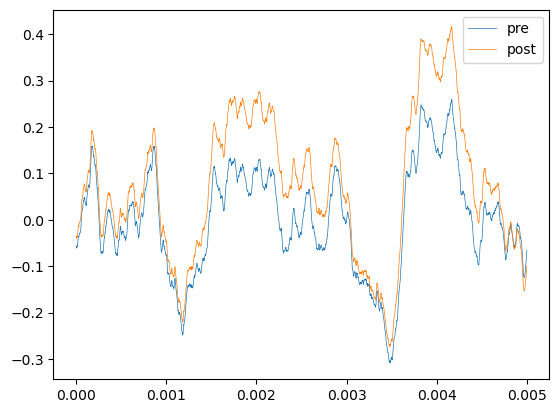

In [6]:
# Apply the transfer function

# To account for near zero DC transfer we apply tikhonov regularization. We find alpha to be the frequency in which noise (low f) begins to dominate (around 100Hz)

# We will appky the following to the signal S:   U = S/T    -->  U = S*T/(T^2 + L^2)      where U is the underlying signal, S is the raw signal, T is the transfer function and L is some paramter lambda

def transfer_func1(f):
    C = 1 / (10**-6*1000)
    x_c = 1j*f*2*np.pi
    A = 4000
    Sallen_key = x_c**2 / (x_c**2 + A*x_c + (1/3)*(A)**2)
    RC_high_pass = x_c / (x_c+C)
    return Sallen_key*RC_high_pass

def low_freq_fit(f):
    C = 1 / (10**-6*1000)
    x_c = 1j*f*2*np.pi
    #A = 4000
    A = 4.66255013e+03
    Sallen_key = x_c**2 / (x_c**2 + A*x_c + 15909216.44677893/3)
    RC_high_pass = x_c / (x_c +C)
    return np.abs(Sallen_key)

# This number (100Hz) was found by visually inspecting the PSD, observing where the low f noise takes over (100Hz), and choosing lamda to be the magnitude of the transfer function at 100Hz so that the lamda term begins to take over when f > 100 Hz
lda = np.abs(low_freq_fit(high_pass))

traces_post_transfer = []

for trace in traces:
    # apply the transfer and convert back
    freq_domain_data = scipy.fft.fft(trace)
    frequencies = scipy.fft.fftfreq(len(trace), time[1] - time[0])
    transfer = low_freq_fit(frequencies)

    freq_domain_data_transfer = (freq_domain_data*np.conj(transfer))/(np.real(transfer)**2 + np.imag(transfer)**2 + lda**2)
    data = np.fft.ifft(freq_domain_data_transfer)

    traces_post_transfer.append(np.real(data))


plt.plot(time[:10000], traces[0][:10000], label = "pre", linewidth=.5)
plt.plot(time[:10000], traces_post_transfer[0][:10000], label = "post", linewidth=.5)
plt.legend()
plt.show()

# Visualize transfer functions

# frequencies1 = scipy.fft.fftfreq(len(traces[0]), time[1] - time[0])
# transfer1 = transfer_func(frequencies1)
#
# plt.plot(frequencies1, np.abs(transfer1), ".", label="Transfer Function", linewidth=.5)
# plt.plot(frequencies1, np.abs((np.real(transfer1)**2 + np.imag(transfer1)**2 + lda**2)/np.conj(transfer1)), ".", label="Effective Transfer Function", linewidth=.5)
# plt.ylim(bottom=1e-8)
# plt.xscale("log")
# plt.yscale("log")
# plt.axvline(x = 100, color = "r", linestyle = "--")
# plt.legend()
# plt.show()

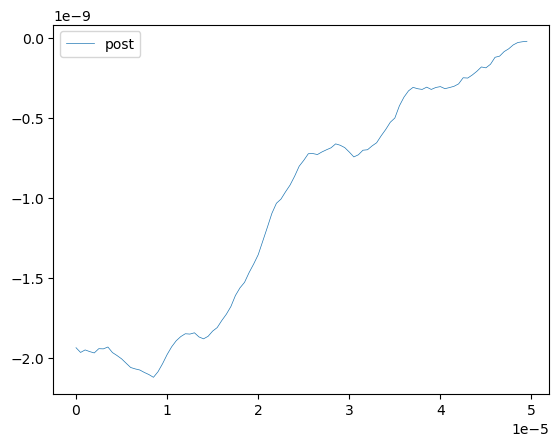

In [7]:
# Convert volts to meters
# This factor was found by fitting to the PSD

v_squared = V
v = math.sqrt(v_squared)

traces_post_meter = []
for trace in traces_post_transfer:
    traces_post_meter.append(np.real(trace / v))

# plt.plot(time[:10000], traces_post_transfer[0][:10000], label = "pre", linewidth=.5)
plt.plot(time[:100], traces_post_meter[0][:100], label = "post", linewidth=.5)
plt.legend()
plt.show()

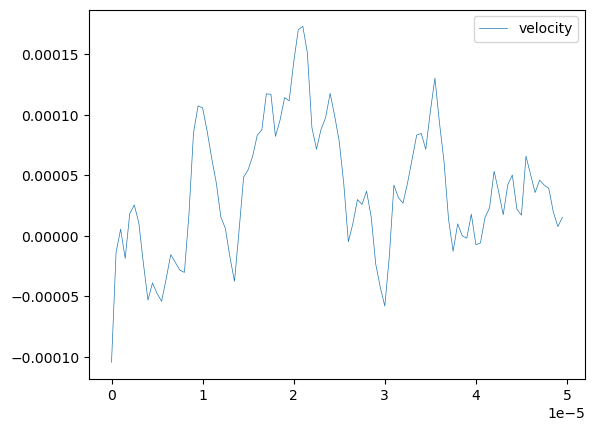

In [8]:
# Apply second order finite differences to find velocity traces

from findiff import Diff

def get_velocity_higher_order(data, time, order):
    der = Diff(0, time[1] - time[0], acc = order)
    return der(data)

velocity_traces = []
for trace in traces_post_meter:
    velocity = get_velocity_higher_order(trace, time, 2)
    velocity_traces.append(velocity)

plt.plot(time[:100], velocity_traces[0][:100], label = "velocity", linewidth=.5)
plt.legend()
plt.show()

In [9]:
# We now want to save off three files
# The voltage to meter converted position and velocity trace, and the non voltage to meter converted position traces

filenames_and_data = {"barium_titanate_in_acetone_voltages": traces_post_transfer,
                      "barium_titanate_in_acetone_position": traces_post_meter,
                      "barium_titanate_in_acetone_velocity": velocity_traces}

for filename in filenames_and_data:
    output_path = r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\April_data\\"
    output_file = f"{filename}.csv"
    file_path = output_path + output_file

    save_results_to_csv(filenames_and_data[filename], file_path)

Data saved to C:\Users\mcthu\OneDrive\Desktop\Lab Data\April_data\\barium_titanate_in_acetone_voltages.csv
Data saved to C:\Users\mcthu\OneDrive\Desktop\Lab Data\April_data\\barium_titanate_in_acetone_position.csv
Data saved to C:\Users\mcthu\OneDrive\Desktop\Lab Data\April_data\\barium_titanate_in_acetone_velocity.csv


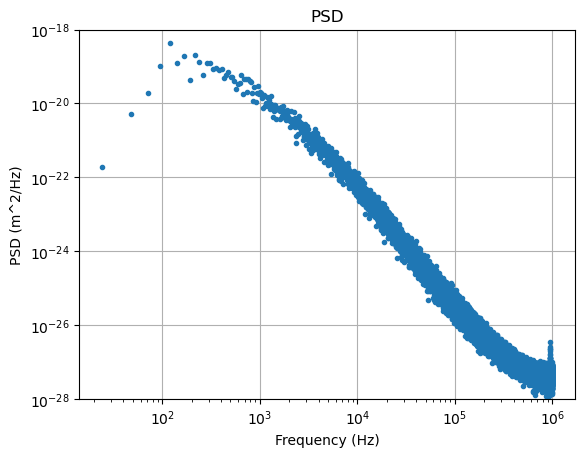

In [10]:
# Check our PSD
psds = []
frequency = 0
for trace in traces_post_meter:
    frequency, psd = scipy.signal.periodogram(trace, fs=fs, scaling="density")
    psds.append(psd)
psd = np.mean(psds, axis=0)
plt.plot(frequency, psd, ".")
plt.ylim(bottom=1e-28, top = 1e-18)
# plt.xlim(left = 100)
# plt.xlim(left=1e4)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (m^2/Hz)")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title("PSD")
plt.show()

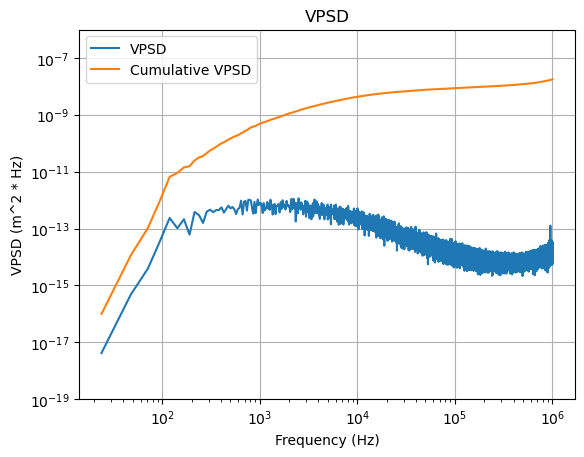

In [11]:
# Check our VPSD
vpsds = []
frequency = 0
for trace in velocity_traces:
    frequency, vpsd = scipy.signal.periodogram(trace, fs=fs, scaling="density")
    vpsds.append(vpsd)
vpsd = np.mean(vpsds, axis=0)
# plt.plot(frequency, vpsd, label = "VPSD")
cumulative_vpsd = np.cumsum(vpsd) * (frequency[1] - frequency[0])  # assuming uniform frequency spacing
# plt.plot(frequency, cumulative_vpsd, label="Cumulative VPSD")
plt.ylim(bottom=1e-19)
plt.ylim(top=1e-6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("VPSD (m^2 * Hz)")
plt.title("VPSD")
plt.grid()

vpsd2 = psd*(2*math.pi*frequency)**2
cumulative_vpsd2 = np.cumsum(vpsd2) * (frequency[1] - frequency[0])  # assuming uniform frequency spacing
plt.plot(frequency[1:], vpsd2[1:], label = "VPSD")
plt.plot(frequency[1:], cumulative_vpsd2[1:], label="Cumulative VPSD")
plt.legend()
plt.show()

In [12]:
from tqdm import tqdm
def compute_VACF_time_domain(v_series):
    n = len(v_series)
    vacf = np.zeros(n)
    for lag in tqdm(range(n), desc="VACF Compute"):
        vacf[lag] = np.dot(v_series[:n - lag], v_series[lag:]) / (
                n - lag)  # Normalize by number of overlapping terms
    return vacf

all_vacf = []
#
# for series in traces_post_meter:
#     v_series = np.diff(series) / np.diff(time)
#     vacf = compute_VACF_time_domain(v_series)
#     all_vacf.append(vacf)

for trace in velocity_traces:
    vacf = compute_VACF_time_domain(trace)
    all_vacf.append(vacf)

VACF Compute: 100%|██████████| 83886/83886 [00:06<00:00, 12614.18it/s]


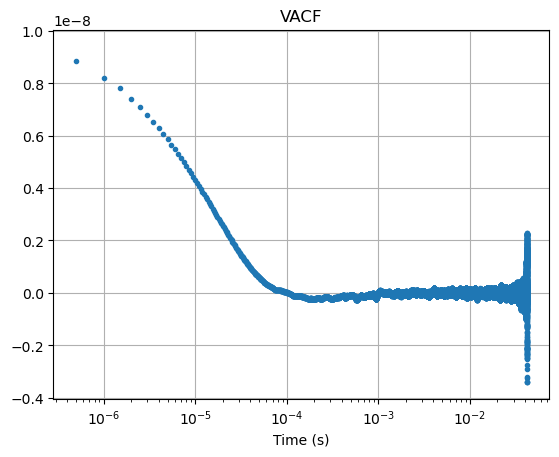

In [13]:
avg_vacf = np.mean(all_vacf, axis=0)

plt.plot(time, avg_vacf, ".")
plt.xscale('log')
# plt.xlim(right=1e-3)
plt.xlabel("Time (s)")
plt.title("VACF")
plt.grid()

100%|██████████| 83886/83886 [00:04<00:00, 17624.51it/s]


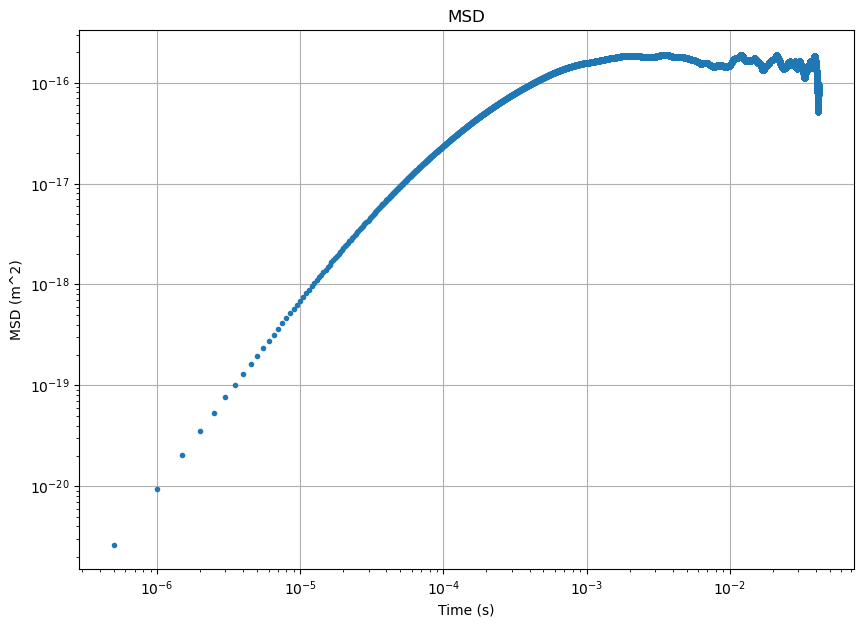

In [14]:
def compute_msd(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(n) * dt  # Calculate lag times

    for tau in tqdm(range(n)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)

    return msd, lag_times

all_hp_msd = []
lag_times = 0
for series in traces_post_meter:
    msd, lag_times = compute_msd(series, 1/fs)
    all_hp_msd.append(msd)

hp_avg_msd = np.mean(all_hp_msd, axis=0)
plt.figure(figsize=(10, 7))
plt.plot(lag_times, hp_avg_msd, ".", label='HP Average MSD')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")
plt.title("MSD")
plt.grid(True)


In [15]:
import pandas as pd
#COMPARE TO SIMULATION
# Load the CSV and split into two arrays
df_loaded = pd.read_csv("msdarr.csv")

# Convert back to NumPy arrays
times_sim = df_loaded["Array1"].to_numpy()
msd_sim = df_loaded["Array2"].to_numpy()

print(times_sim, msd_sim)

hp_avg_msd = np.mean(all_hp_msd, axis=0)
plt.figure(figsize=(10, 7))
plt.plot(lag_times, hp_avg_msd, ".", label='HP Average MSD')
plt.plot(times_sim, msd_sim, ".", label='SIM MSD')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")
plt.title("MSD")
plt.legend()
plt.grid(True)

FileNotFoundError: [Errno 2] No such file or directory: 'msdarr.csv'

Area under PDF Velocity: 0.9999994261993681
Total Counts: 671088
Bin Width: 1.7060935192059158e-06
Area under normalized histogram: 1.0
500


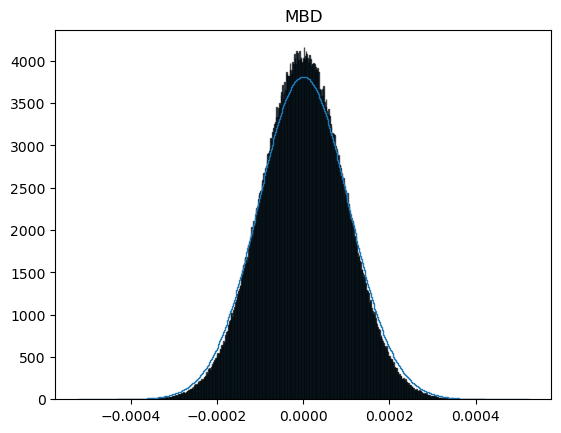

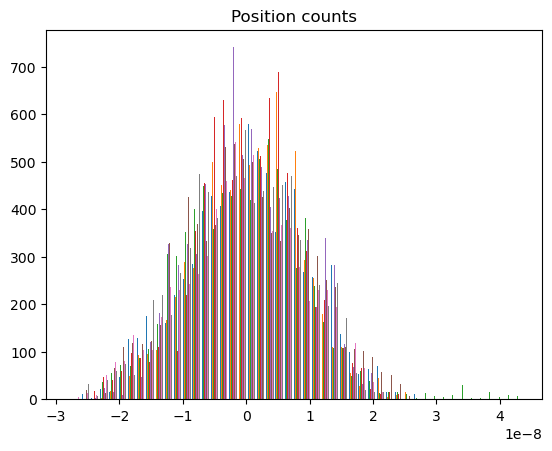

In [31]:
# See velocity distribution
from scipy.stats import maxwell, norm
from scipy import constants

T = 297
r = 2.69e-6
m = 4200*(4/3)*np.pi*r**3 + 789*.5*(4/3)*math.pi*r**3

sigma_v = np.sqrt(constants.k * T / m)

v = np.linspace(-5* sigma_v, 5 * sigma_v, 500)

pdf = np.sqrt(m/(2*math.pi*constants.k*T))*np.exp((-m*v**2)/(2*constants.k*T))

area_pdf_velocity = np.trapz(pdf, v)  # Should be close to 1
print(f"Area under PDF Velocity: {area_pdf_velocity}")

counts, bin_edges = np.histogram(velocity_traces, bins=500, density=False)

# Compute bin width
bin_width = bin_edges[1] - bin_edges[0]

# Normalize counts to make total area = 1
normalized_counts = counts / (np.sum(counts) * bin_width)

print(f"Total Counts: {np.sum(counts)}")
print(f"Bin Width: {bin_width}")

# Verify Histogram Area
area_hist = np.sum(normalized_counts * bin_width)
print(f"Area under normalized histogram: {area_hist}")

# Plot the normalized histogram
plt.bar(bin_edges[:-1], normalized_counts, width=bin_width, edgecolor='k', alpha=0.7)
print(len(normalized_counts))
plt.title("Velocity Counts")

plt.hist(v, weights=pdf, bins=500, histtype='step')
plt.title("MBD")
plt.show()

plt.hist(traces_post_meter, bins=500)
plt.title("Position counts")
plt.show()